# 🥇 Gold Price Prediction - Ensemble ML Trading System

This notebook trains **5 different ML models** and combines them for optimal trading predictions.

## 🤖 Models Used:
1. **LSTM** - Deep learning for sequential patterns
2. **Random Forest** - Ensemble of decision trees
3. **Gradient Boosted Trees (GBRT)** - Sequential boosting
4. **XGBoost** - Extreme gradient boosting
5. **KNN** - Pattern matching with similar historical setups

## 📥 Data Source:
- XAUUSD H1 (Hourly) data
- 10 years: 2015-2025
- 64,644 hourly candles

## 🎯 Output Predictions:
- **Entry Signal**: BUY / SELL / HOLD
- **Entry Price**: Optimal price to enter
- **Stop Loss**: Risk management level
- **Take Profit**: Target exit price
- **Confidence**: Model agreement score

## 📊 Features:
- 60-period sliding window
- 20+ technical indicators
- Ensemble voting system
- Risk/Reward optimization


In [17]:
# Step 1: Install Required Libraries
%pip install numpy pandas matplotlib plotly scikit-learn tensorflow xgboost lightgbm joblib --quiet

print("✅ Libraries installed!")


Note: you may need to restart the kernel to use updated packages.
✅ Libraries installed!


In [18]:
# Step 2: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import pickle
import joblib
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import (mean_absolute_percentage_error, mean_squared_error, 
                             accuracy_score, classification_report, confusion_matrix)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# XGBoost
import xgboost as xgb

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import (Input, Dense, Dropout, LSTM, Bidirectional, 
                          BatchNormalization, Concatenate, GlobalAveragePooling1D,
                          GlobalMaxPooling1D, Conv1D, MaxPooling1D)
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

print("="*60)
print("🤖 ENSEMBLE ML TRADING SYSTEM")
print("="*60)
print(f"✅ TensorFlow: {tf.__version__}")
print(f"✅ XGBoost: {xgb.__version__}")
print(f"✅ NumPy: {np.__version__}")
print(f"✅ Pandas: {pd.__version__}")
print("✅ RandomForest, GBRT: sklearn")
print("="*60)


🤖 ENSEMBLE ML TRADING SYSTEM
✅ TensorFlow: 2.20.0
✅ XGBoost: 3.1.2
✅ NumPy: 1.26.4
✅ Pandas: 2.3.3
✅ RandomForest, GBRT: sklearn


In [19]:
# Step 3: Configuration - PURE SCALPING (Technical Only)
USE_MT5_CONNECTION = False

# CSV file exported from MT5
CSV_PATH = 'XAUUSD_H1_201501020900_202512221100.csv'

# Model Settings
SYMBOL = 'XAUUSD'
WINDOW_SIZE = 20   # 20 hours lookback (short for scalping)
TIMEFRAME = 'H1'   # Hourly data

# =============================================================================
# SCALPING CONFIGURATION - PURE TECHNICAL ANALYSIS
# =============================================================================
TRADING_STYLE = 'SCALPING'  # Quick in-and-out trades

# Prediction horizon - SHORT for scalping
PREDICTION_HORIZON = 2    # 2-hour ahead (scalping timeframe)

# Threshold - SMALL for frequent scalp opportunities
# Gold typically moves 10-30 pips per hour, so 0.2% (20 pips) is realistic
TREND_THRESHOLD = 0.002   # 0.20% move = 20 pips target

print("="*60)
print("⚡ PURE SCALPING CONFIGURATION - TECHNICAL ONLY")
print("="*60)
print(f"   Data: {CSV_PATH}")
print(f"   Timeframe: {TIMEFRAME}")
print(f"   Window: {WINDOW_SIZE} periods lookback")
print(f"\n🎯 TRADING STYLE: {TRADING_STYLE}")
print(f"   Prediction:  {PREDICTION_HORIZON}H ahead")
print(f"   Target:      >{TREND_THRESHOLD*100:.2f}% move (20 pips)")
print(f"\n⚡ SCALPING FEATURES:")
print(f"   - Fast indicators (5, 10, 14 periods)")
print(f"   - Price action patterns only")
print(f"   - NO fundamental factors")
print(f"   - NO session/day-of-week features")
print("="*60)


⚡ PURE SCALPING CONFIGURATION - TECHNICAL ONLY
   Data: XAUUSD_H1_201501020900_202512221100.csv
   Timeframe: H1
   Window: 20 periods lookback

🎯 TRADING STYLE: SCALPING
   Prediction:  2H ahead
   Target:      >0.20% move (20 pips)

⚡ SCALPING FEATURES:
   - Fast indicators (5, 10, 14 periods)
   - Price action patterns only
   - NO fundamental factors
   - NO session/day-of-week features


In [20]:
# Step 4: Load Data from MT5 Exported CSV
print(f"📂 Loading data from: {CSV_PATH}")

# Load the MT5 exported CSV (tab-separated)
df = pd.read_csv(CSV_PATH, sep='\t')

# Rename columns to standard format
df = df.rename(columns={
    '<DATE>': 'Date',
    '<TIME>': 'Time', 
    '<OPEN>': 'Open',
    '<HIGH>': 'High',
    '<LOW>': 'Low',
    '<CLOSE>': 'Price',
    '<TICKVOL>': 'TickVolume',
    '<VOL>': 'Volume',
    '<SPREAD>': 'Spread'
})

# Combine Date and Time into DateTime
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y.%m.%d %H:%M:%S')
df = df.drop(columns=['Time'])

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

# Select main columns
df = df[['Date', 'Open', 'High', 'Low', 'Price', 'Volume']]

print(f"✅ Loaded {len(df):,} records")
print(f"   Timeframe: {TIMEFRAME} (Hourly)")
print(f"   Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"   Price range: ${df['Price'].min():.2f} - ${df['Price'].max():.2f}")
print(f"   Latest price: ${df['Price'].iloc[-1]:.2f}")

df.head(10)


📂 Loading data from: XAUUSD_H1_201501020900_202512221100.csv
✅ Loaded 64,642 records
   Timeframe: H1 (Hourly)
   Date range: 2015-01-02 09:00:00 to 2025-12-22 11:00:00
   Price range: $1050.05 - $4419.53
   Latest price: $4413.26


Date     Open     High      Low    Price   Volume
0 2015-01-02 09:00:00  1186.94  1187.15  1184.67  1185.85  1376300
1 2015-01-02 10:00:00  1185.85  1188.00  1185.85  1186.60  1538500
2 2015-01-02 11:00:00  1186.60  1186.99  1184.75  1186.23  1535800
3 2015-01-02 12:00:00  1186.25  1186.78  1181.20  1182.57  1903400
4 2015-01-02 13:00:00  1182.55  1183.79  1180.57  1182.68  2379600
5 2015-01-02 14:00:00  1182.74  1183.54  1173.55  1177.14  3330500
6 2015-01-02 15:00:00  1177.11  1178.16  1167.33  1174.17  5197700
7 2015-01-02 16:00:00  1174.13  1174.47  1169.16  1171.64  4973700
8 2015-01-02 17:00:00  1171.74  1194.29  1171.49  1187.94  7500600
9 2015-01-02 18:00:00  1187.94  1195.03  1187.62  1192.27  4275000

In [21]:
# Step 5: Data Preparation
columns_to_drop = ['Vol.', 'Change %', 'vol', 'change']
for col in columns_to_drop:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

numeric_cols = df.columns.drop(['Date'])
for col in numeric_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].replace({',': ''}, regex=True)
        df[col] = df[col].astype('float64')

print(f"Data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Price range: ${df['Price'].min():.2f} - ${df['Price'].max():.2f}")
df.info()


Data shape: (64642, 6)
Date range: 2015-01-02 09:00:00 to 2025-12-22 11:00:00
Price range: $1050.05 - $4419.53
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64642 entries, 0 to 64641
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    64642 non-null  datetime64[ns]
 1   Open    64642 non-null  float64       
 2   High    64642 non-null  float64       
 3   Low     64642 non-null  float64       
 4   Price   64642 non-null  float64       
 5   Volume  64642 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 3.0 MB


In [22]:
# Step 6: Add Technical Indicators (PURE SCALPING - Technical Only)

def add_technical_indicators(df):
    """Add PURE TECHNICAL indicators for SCALPING - NO fundamental factors"""
    
    print("⚡ Adding SCALPING indicators (technical only)...")
    
    # ==========================================================================
    # TREND INDICATORS (most predictive for direction)
    # ==========================================================================
    
    # Multi-timeframe Moving Average Crossovers (strong trend signals)
    df['SMA_5'] = df['Price'].rolling(window=5).mean()
    df['SMA_10'] = df['Price'].rolling(window=10).mean()
    df['SMA_20'] = df['Price'].rolling(window=20).mean()
    df['SMA_50'] = df['Price'].rolling(window=50).mean()
    
    # MA Crossover signals (1 = bullish, -1 = bearish, 0 = neutral)
    df['MA_Cross_5_20'] = np.where(df['SMA_5'] > df['SMA_20'], 1, -1)
    df['MA_Cross_10_50'] = np.where(df['SMA_10'] > df['SMA_50'], 1, -1)
    
    # Price position relative to MAs
    df['Price_vs_SMA20'] = (df['Price'] - df['SMA_20']) / df['SMA_20']
    df['Price_vs_SMA50'] = (df['Price'] - df['SMA_50']) / df['SMA_50']
    
    # Trend strength (how far from MAs)
    df['Trend_Strength'] = df['Price_vs_SMA20'].abs() + df['Price_vs_SMA50'].abs()
    
    # ==========================================================================
    # MOMENTUM INDICATORS
    # ==========================================================================
    
    # RSI with zones
    delta = df['Price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))
    df['RSI_Signal'] = np.where(df['RSI'] > 70, -1, np.where(df['RSI'] < 30, 1, 0))
    
    # MACD
    exp12 = df['Price'].ewm(span=12, adjust=False).mean()
    exp26 = df['Price'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['MACD_Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal_Line']
    df['MACD_Cross'] = np.where(df['MACD'] > df['MACD_Signal_Line'], 1, -1)
    
    # Rate of Change
    df['ROC_5'] = (df['Price'] - df['Price'].shift(5)) / df['Price'].shift(5)
    df['ROC_10'] = (df['Price'] - df['Price'].shift(10)) / df['Price'].shift(10)
    
    # ==========================================================================
    # VOLATILITY & RANGE
    # ==========================================================================
    
    # ATR normalized
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                         np.maximum(abs(df['High'] - df['Price'].shift(1)),
                                   abs(df['Low'] - df['Price'].shift(1))))
    df['ATR'] = df['TR'].rolling(window=14).mean()
    df['ATR_Pct'] = df['ATR'] / df['Price']
    
    # Bollinger Band position
    bb_sma = df['Price'].rolling(window=20).mean()
    bb_std = df['Price'].rolling(window=20).std()
    df['BB_Upper'] = bb_sma + (2 * bb_std)
    df['BB_Lower'] = bb_sma - (2 * bb_std)
    df['BB_Position'] = (df['Price'] - bb_sma) / (2 * bb_std + 1e-10)
    
    # ==========================================================================
    # CANDLESTICK PATTERNS (simplified)
    # ==========================================================================
    
    df['Body'] = (df['Price'] - df['Open']) / df['Open']
    df['Upper_Shadow'] = (df['High'] - np.maximum(df['Price'], df['Open'])) / df['Price']
    df['Lower_Shadow'] = (np.minimum(df['Price'], df['Open']) - df['Low']) / df['Price']
    
    # ==========================================================================
    # SCALPING INDICATORS (Fast, reactive)
    # ==========================================================================
    
    # Fast RSI (5-period for scalping)
    delta_fast = df['Price'].diff()
    gain_fast = (delta_fast.where(delta_fast > 0, 0)).rolling(window=5).mean()
    loss_fast = (-delta_fast.where(delta_fast < 0, 0)).rolling(window=5).mean()
    rs_fast = gain_fast / (loss_fast + 1e-10)
    df['RSI_Fast'] = 100 - (100 / (1 + rs_fast))
    
    # Fast MA crossover (for scalping entries)
    df['EMA_3'] = df['Price'].ewm(span=3, adjust=False).mean()
    df['EMA_8'] = df['Price'].ewm(span=8, adjust=False).mean()
    df['Scalp_Cross'] = np.where(df['EMA_3'] > df['EMA_8'], 1, -1)
    
    # Price momentum (last 3 candles)
    df['Momentum_3'] = (df['Price'] - df['Price'].shift(3)) / df['Price'].shift(3)
    
    # ==========================================================================
    # VOLATILITY INDICATORS (to choose scalp vs swing)
    # ==========================================================================
    
    # Volatility regime (high = scalp, low = swing)
    df['Volatility'] = df['ATR_Pct'].rolling(window=10).mean()
    df['Volatility_Ratio'] = df['ATR_Pct'] / df['Volatility']  # >1 = high vol
    
    # ==========================================================================
    # FAST MOMENTUM (for scalping entries)
    # ==========================================================================
    
    # Stochastic Oscillator (fast for scalping)
    low_14 = df['Low'].rolling(14).min()
    high_14 = df['High'].rolling(14).max()
    df['Stoch_K'] = 100 * (df['Price'] - low_14) / (high_14 - low_14 + 1e-10)
    df['Stoch_D'] = df['Stoch_K'].rolling(3).mean()
    df['Stoch_Signal'] = np.where(df['Stoch_K'] > df['Stoch_D'], 1, -1)
    
    # Fast Stochastic (5-period for scalping)
    low_5 = df['Low'].rolling(5).min()
    high_5 = df['High'].rolling(5).max()
    df['Stoch_Fast'] = 100 * (df['Price'] - low_5) / (high_5 - low_5 + 1e-10)
    
    # Williams %R (momentum oscillator)
    df['Williams_R'] = -100 * (high_14 - df['Price']) / (high_14 - low_14 + 1e-10)
    
    # CCI (Commodity Channel Index) - good for gold
    typical_price = (df['High'] + df['Low'] + df['Price']) / 3
    sma_tp = typical_price.rolling(20).mean()
    mad = typical_price.rolling(20).apply(lambda x: np.abs(x - x.mean()).mean())
    df['CCI'] = (typical_price - sma_tp) / (0.015 * mad + 1e-10)
    df['CCI_Signal'] = np.where(df['CCI'] > 100, -1, np.where(df['CCI'] < -100, 1, 0))
    
    # ==========================================================================
    # PRICE ACTION PATTERNS (pure technical)
    # ==========================================================================
    
    # Candle patterns
    df['Up_Candle'] = (df['Price'] > df['Open']).astype(int)
    df['Consecutive_Up'] = df['Up_Candle'].rolling(3).sum()
    df['Consecutive_Down'] = 3 - df['Consecutive_Up']
    
    # Candle size relative to ATR
    df['Candle_Size'] = abs(df['Price'] - df['Open']) / (df['ATR'] + 1e-10)
    
    # Wick ratios (rejection patterns)
    candle_range = df['High'] - df['Low'] + 1e-10
    df['Upper_Wick_Ratio'] = (df['High'] - df[['Open', 'Price']].max(axis=1)) / candle_range
    df['Lower_Wick_Ratio'] = (df[['Open', 'Price']].min(axis=1) - df['Low']) / candle_range
    
    # Engulfing pattern detection
    df['Prev_Body'] = (df['Price'].shift(1) - df['Open'].shift(1)).abs()
    df['Curr_Body'] = (df['Price'] - df['Open']).abs()
    df['Engulfing'] = ((df['Curr_Body'] > df['Prev_Body'] * 1.5) & 
                       (df['Up_Candle'] != df['Up_Candle'].shift(1))).astype(int)
    
    # ==========================================================================
    # SUPPORT/RESISTANCE LEVELS (technical)
    # ==========================================================================
    
    # Recent high/low levels
    df['Recent_High'] = df['High'].rolling(10).max()
    df['Recent_Low'] = df['Low'].rolling(10).min()
    df['Near_Resistance'] = (df['Price'] > df['Recent_High'] * 0.998).astype(int)
    df['Near_Support'] = (df['Price'] < df['Recent_Low'] * 1.002).astype(int)
    
    # Distance from S/R levels
    df['Dist_From_High'] = (df['Recent_High'] - df['Price']) / df['Price']
    df['Dist_From_Low'] = (df['Price'] - df['Recent_Low']) / df['Price']
    
    # ==========================================================================
    # SCALPING TARGET (2-hour ahead)
    # ==========================================================================
    
    # Single short-term target for scalping
    df['Target'] = df['Price'].shift(-PREDICTION_HORIZON) / df['Price'] - 1
    
    print(f"   ✅ Target: {PREDICTION_HORIZON}H ahead")
    print(f"   ✅ Fast oscillators (Stoch, Williams %R, CCI)")
    print(f"   ✅ Price action patterns (engulfing, wicks)")
    print(f"   ✅ Support/Resistance levels")
    print(f"   ✅ NO fundamental factors (sessions, day-of-week removed)")
    
    # Drop NaN rows
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

df = add_technical_indicators(df)
print(f"✅ Dataset shape after adding indicators: {df.shape}")
print(f"   Features added: {len(df.columns) - 6}")
print(f"\n📊 Target (Next Return) statistics:")
print(f"   Mean: {df['Target'].mean()*100:.4f}%")
print(f"   Std: {df['Target'].std()*100:.4f}%")
print(f"   Min: {df['Target'].min()*100:.2f}%")
print(f"   Max: {df['Target'].max()*100:.2f}%")
df.head()


⚡ Adding SCALPING indicators (technical only)...
   ✅ Target: 2H ahead
   ✅ Fast oscillators (Stoch, Williams %R, CCI)
   ✅ Price action patterns (engulfing, wicks)
   ✅ Support/Resistance levels
   ✅ NO fundamental factors (sessions, day-of-week removed)
✅ Dataset shape after adding indicators: (64591, 62)
   Features added: 56

📊 Target (Next Return) statistics:
   Mean: 0.0044%
   Std: 0.2657%
   Min: -4.29%
   Max: 5.16%


Date     Open     High      Low    Price   Volume     SMA_5  \
0 2015-01-06 12:00:00  1213.26  1213.31  1210.20  1210.83  1562760  1210.494   
1 2015-01-06 13:00:00  1210.81  1211.80  1208.77  1209.94  1185970  1210.820   
2 2015-01-06 14:00:00  1209.90  1211.09  1207.98  1210.07   992500  1211.130   
3 2015-01-06 15:00:00  1210.23  1214.00  1208.62  1210.54  1936488  1210.932   
4 2015-01-06 16:00:00  1210.49  1211.51  1208.08  1209.77  1171900  1210.230   

     SMA_10     SMA_20     SMA_50  ...  Prev_Body  Curr_Body  Engulfing  \
0  1207.936  1204.8235  1194.7242  ...       1.77       2.43          0   
1  1208.526  1205.3775  1195.2060  ...       2.43       0.87          0   
2  1209.054  1205.9515  1195.6754  ...       0.87       0.17          0   
3  1209.554  1206.6620  1196.1616  ...       0.17       0.31          0   
4  1209.875  1207.1100  1196.7056  ...       0.31       0.72          1   

   Recent_High  Recent_Low  Near_Resistance  Near_Support  Dist_From_High  \
0      1214.16     1202.40                0             0        0.002750   
1      1214.16     1203.94                0             0        0.003488   
2      1214.16     1204.45                0             0        0.003380   
3      1214.16     1205.18                0             0        0.002990   
4      1214.16     1205.18                0             0        0.003629   

   Dist_From_Low    Target  
0       0.006962 -0.000628  
1       0.004959  0.000496  
2       0.004644 -0.000248  
3       0.004428 -0.001520  
4       0.003794  0.008150  

[5 rows x 62 columns]

In [23]:
# Step 7: Visualize Gold Price
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Price'], mode='lines', name='Gold Price', line=dict(color='gold', width=2)))
fig.update_layout(title='🥇 Gold Price History (XAUUSD)', xaxis_title='Date', yaxis_title='Price (USD)', template='plotly_dark')
fig.show()


In [24]:
# Step 8: Select Features and Prepare Training Data
# PURE SCALPING - Technical Only (NO fundamentals)

feature_columns = [
    # FAST TREND (short-term only)
    'MA_Cross_5_20', 'MA_Cross_10_50',
    'Price_vs_SMA20', 'Price_vs_SMA50', 'Trend_Strength',
    'Scalp_Cross',  # EMA 3/8 cross
    
    # FAST MOMENTUM (scalping oscillators)
    'RSI', 'RSI_Signal', 'RSI_Fast',
    'MACD_Cross', 'MACD_Histogram',
    'ROC_5', 'ROC_10', 'Momentum_3',
    
    # STOCHASTIC (key for scalping)
    'Stoch_K', 'Stoch_D', 'Stoch_Signal', 'Stoch_Fast',
    
    # OTHER OSCILLATORS
    'Williams_R', 'CCI', 'CCI_Signal',
    
    # VOLATILITY
    'ATR_Pct', 'BB_Position', 'Volatility_Ratio',
    
    # PRICE ACTION (pure technical)
    'Body', 'Upper_Shadow', 'Lower_Shadow',
    'Candle_Size', 'Upper_Wick_Ratio', 'Lower_Wick_Ratio',
    'Engulfing', 'Consecutive_Up', 'Consecutive_Down',
    
    # SUPPORT/RESISTANCE (technical)
    'Near_Resistance', 'Near_Support',
    'Dist_From_High', 'Dist_From_Low'
]

feature_columns = [col for col in feature_columns if col in df.columns]
print(f"✅ Using {len(feature_columns)} MID-INTRADAY features:")
for i, col in enumerate(feature_columns):
    print(f"   {i+1}. {col}")

# Extract features and target (PURE SCALPING - single target)
X_data = df[feature_columns].values
y_data = df['Target'].values  # Scalp target (2H ahead)
dates = df['Date'].values
prices = df['Price'].values

# Also save volatility for trade type decision
volatility_data = df['Volatility_Ratio'].values if 'Volatility_Ratio' in df.columns else None

# Time-series split (80% train, 20% test)
test_size = int(len(X_data) * 0.2)
train_size = len(X_data) - test_size - WINDOW_SIZE

print(f"\n📊 Data split (time-series):")
print(f"   Training: {train_size:,} samples")
print(f"   Test: {test_size:,} samples")
print(f"   Window: {WINDOW_SIZE} periods")
print(f"\n🎯 Scalp Target: {PREDICTION_HORIZON}H ahead")


✅ Using 37 MID-INTRADAY features:
   1. MA_Cross_5_20
   2. MA_Cross_10_50
   3. Price_vs_SMA20
   4. Price_vs_SMA50
   5. Trend_Strength
   6. Scalp_Cross
   7. RSI
   8. RSI_Signal
   9. RSI_Fast
   10. MACD_Cross
   11. MACD_Histogram
   12. ROC_5
   13. ROC_10
   14. Momentum_3
   15. Stoch_K
   16. Stoch_D
   17. Stoch_Signal
   18. Stoch_Fast
   19. Williams_R
   20. CCI
   21. CCI_Signal
   22. ATR_Pct
   23. BB_Position
   24. Volatility_Ratio
   25. Body
   26. Upper_Shadow
   27. Lower_Shadow
   28. Candle_Size
   29. Upper_Wick_Ratio
   30. Lower_Wick_Ratio
   31. Engulfing
   32. Consecutive_Up
   33. Consecutive_Down
   34. Near_Resistance
   35. Near_Support
   36. Dist_From_High
   37. Dist_From_Low

📊 Data split (time-series):
   Training: 51,653 samples
   Test: 12,918 samples
   Window: 20 periods

🎯 Scalp Target: 2H ahead


In [25]:
# Step 9: Scale Data
from sklearn.preprocessing import RobustScaler

# Use RobustScaler - better for financial data with outliers
scaler = RobustScaler()

# Split data
train_end = len(X_data) - test_size
X_train_raw = X_data[:train_end]
X_test_raw = X_data[train_end - WINDOW_SIZE:]  # Include window for sequences
y_train_raw = y_data[:train_end]
y_test_raw = y_data[train_end:]

# Fit scaler only on training data
scaler.fit(X_train_raw)

X_train_scaled = scaler.transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Scale target (returns) - use simple standardization
y_mean = y_train_raw.mean()
y_std = y_train_raw.std()
y_train_scaled = (y_train_raw - y_mean) / y_std
y_test_scaled = (y_test_raw - y_mean) / y_std

# Save scaler parameters for MT5
scaler_params = {
    'feature_scaler': {
        'center_': scaler.center_.tolist(),
        'scale_': scaler.scale_.tolist(),
    },
    'target_scaler': {
        'mean': float(y_mean),
        'std': float(y_std)
    },
    'feature_columns': feature_columns,
    'window_size': WINDOW_SIZE
}
with open('scaler_params.json', 'w') as f:
    json.dump(scaler_params, f, indent=2)

print("✅ Data scaled successfully")
print(f"   Feature range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")
print(f"   Target mean: {y_mean*100:.4f}%, std: {y_std*100:.4f}%")


✅ Data scaled successfully
   Feature range: [-26.27, 50.84]
   Target mean: 0.0021%, std: 0.2586%


In [26]:
# Step 10: Create Sliding Window Sequences
def create_sequences(X_data, y_data, window_size):
    """Create sequences for LSTM - predict next return from window of features"""
    X, y = [], []
    for i in range(window_size, len(X_data)):
        X.append(X_data[i-window_size:i])
        if i < len(y_data):
            y.append(y_data[i])
    return np.array(X), np.array(y)

# Create training sequences
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, WINDOW_SIZE)

# Create test sequences
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, WINDOW_SIZE)

# Keep corresponding dates and prices for evaluation
test_dates = dates[train_end:]
test_prices = prices[train_end:]

print(f"✅ Sequences created:")
print(f"   X_train: {X_train.shape} (samples, window, features)")
print(f"   y_train: {y_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")


✅ Sequences created:
   X_train: (51653, 20, 37) (samples, window, features)
   y_train: (51653,)
   X_test: (12918, 20, 37)
   y_test: (12898,)


In [27]:
# Step 11: Build ENSEMBLE MODELS (LSTM + Random Forest + GBRT + XGBoost)
from sklearn.utils.class_weight import compute_class_weight

print("="*70)
print("🤖 TRAINING 4 ML MODELS FOR ENSEMBLE PREDICTION")
print("="*70)

# =============================================================================
# PART 1: Prepare Classification Targets (BINARY for higher accuracy)
# =============================================================================

# Use TREND_THRESHOLD for the primary prediction (24H ahead)
# This is defined in Cell 3 as 0.008 (0.8% = 80 pips - clear moves!)

def create_classification_targets(returns, threshold=TREND_THRESHOLD):
    """
    BINARY classification (optimized for accuracy):
    0 = DOWN (return < -threshold) - Price will go DOWN significantly
    1 = UP (return > threshold) - Price will go UP significantly
    
    We ONLY keep clear moves (>0.8%) to train on strong signals
    """
    classes = np.zeros(len(returns), dtype=int)
    classes[returns < -threshold] = 0  # DOWN
    classes[returns > threshold] = 1   # UP
    # Neutral moves (between -threshold and +threshold) = -1 (filtered out)
    neutral_mask = (returns >= -threshold) & (returns <= threshold)
    classes[neutral_mask] = -1  # Will be filtered out
    return classes

def create_classification_targets_3class(returns, threshold=TREND_THRESHOLD):
    """
    3-class version if needed
    """
    classes = np.zeros(len(returns), dtype=int)
    classes[returns < -threshold] = 0  # SELL/DOWN
    classes[(returns >= -threshold) & (returns <= threshold)] = 1  # HOLD
    classes[returns > threshold] = 2  # BUY/UP
    return classes

# Create classification targets - ensure they match X dimensions
print(f"📐 Data shapes:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")

# Ensure y arrays match X arrays in length
y_train_for_class = y_train_scaled[:len(X_train)]
y_test_for_class = y_test_scaled[:len(X_test)]

# Convert to actual returns
y_train_returns = y_train_for_class * y_std + y_mean
y_test_returns = y_test_for_class * y_std + y_mean

# Create binary classification (DOWN=0, UP=1, Neutral=-1)
y_train_class_raw = create_classification_targets(y_train_returns)
y_test_class_raw = create_classification_targets(y_test_returns)

# Filter out neutral samples (where class == -1) for cleaner training
train_valid_mask = y_train_class_raw != -1
test_valid_mask = y_test_class_raw != -1

X_train_filtered = X_train[train_valid_mask]
y_train_class = y_train_class_raw[train_valid_mask]
X_test_filtered = X_test[test_valid_mask]
y_test_class = y_test_class_raw[test_valid_mask]

# Update X_train and X_test to filtered versions
X_train = X_train_filtered
X_test = X_test_filtered

print(f"\n📊 After filtering neutral moves:")
print(f"   X_train: {X_train.shape} (removed {np.sum(~train_valid_mask):,} neutral)")
print(f"   X_test: {X_test.shape} (removed {np.sum(~test_valid_mask):,} neutral)")
print(f"   y_train_class: {y_train_class.shape}")
print(f"   y_test_class: {y_test_class.shape}")

# Check class distribution (BINARY: DOWN=0, UP=1)
print("\n📊 Class Distribution (BINARY):")
for i, name in enumerate(['DOWN (SELL)', 'UP (BUY)']):
    train_pct = np.sum(y_train_class == i) / len(y_train_class) * 100
    test_pct = np.sum(y_test_class == i) / len(y_test_class) * 100
    print(f"   {name}: Train {train_pct:.1f}%, Test {test_pct:.1f}%")

# Compute class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weight_dict = dict(enumerate(class_weights))
print(f"\n⚖️ Class weights: {class_weight_dict}")
print(f"✅ Binary classification for higher accuracy!")

# =============================================================================
# PREPARE FLATTENED DATA FOR TREE-BASED MODELS
# =============================================================================
# Flatten the 3D sequences to 2D for RF, GBRT, XGBoost
# Use last 20 timesteps only (reduces noise, faster training)
X_train_flat = X_train[:, -20:, :].reshape(X_train.shape[0], -1)
X_test_flat = X_test[:, -20:, :].reshape(X_test.shape[0], -1)
print(f"\n📐 Flattened shape for tree models: {X_train_flat.shape} (last 20 timesteps)")

# Store all model predictions
ensemble_predictions = {}
ensemble_probabilities = {}

# =============================================================================
# MODEL 1: LSTM (Deep Learning)
# =============================================================================
print("\n" + "="*70)
print("🧠 MODEL 1: LSTM Neural Network")
print("="*70)

def build_lstm_model(input_shape, num_classes=2):
    """IMPROVED LSTM with Conv1D for pattern detection"""
    inputs = Input(shape=input_shape, name='input_layer')
    
    # Conv1D for local pattern detection (like candlestick patterns)
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Bidirectional LSTM for both forward and backward patterns
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))(x)
    x = BatchNormalization()(x)
    x = Bidirectional(LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.1))(x)
    x = BatchNormalization()(x)
    
    # Dense layers with regularization
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.4)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    
    # Binary output
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='LSTM_Improved')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]), num_classes=2)
print(f"   Parameters: {lstm_model.count_params():,}")
print(f"   Output: BINARY (DOWN=0, UP=1)")

# =============================================================================
# MODEL 2: Random Forest
# =============================================================================
print("\n" + "="*70)
print("🌲 MODEL 2: Random Forest Classifier")
print("="*70)

rf_model = RandomForestClassifier(
    n_estimators=300,         # More trees for stability
    max_depth=15,             # Reduced depth to prevent overfitting
    min_samples_split=20,     # Require more samples to split
    min_samples_leaf=10,      # Require more samples in leaves
    max_features='sqrt',      # Use sqrt of features per tree
    class_weight='balanced',
    bootstrap=True,
    oob_score=True,           # Out-of-bag score for validation
    n_jobs=-1,
    random_state=42,
    verbose=0
)
print(f"   Estimators: 300, Max Depth: 15 (regularized)")

# =============================================================================
# MODEL 3: Gradient Boosted Trees (GBRT) - OPTIMIZED FOR SPEED
# =============================================================================
print("\n" + "="*70)
print("📈 MODEL 3: Gradient Boosted Regression Trees (GBRT)")
print("="*70)

# Use fewer features for GBRT (last 10 timesteps for speed)
X_train_reduced = X_train[:, -10:, :].reshape(X_train.shape[0], -1)
X_test_reduced = X_test[:, -10:, :].reshape(X_test.shape[0], -1)
print(f"   Using reduced features: {X_train_reduced.shape[1]} (last 10 timesteps)")

gbrt_model = GradientBoostingClassifier(
    n_estimators=100,     # More estimators for accuracy
    max_depth=4,          # Shallow trees to prevent overfitting
    learning_rate=0.05,   # Slower learning
    min_samples_split=30,
    min_samples_leaf=15,
    subsample=0.7,        # More regularization
    max_features='sqrt',  # Feature sampling
    random_state=42,
    verbose=1
)
print(f"   Estimators: 100, Max Depth: 4 (balanced speed/accuracy)")

# =============================================================================
# MODEL 4: XGBoost
# =============================================================================
print("\n" + "="*70)
print("⚡ MODEL 4: XGBoost Classifier")
print("="*70)

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,              # Reduced to prevent overfitting
    learning_rate=0.05,       # Slower learning for better generalization
    subsample=0.7,            # More regularization
    colsample_bytree=0.7,     # More regularization
    colsample_bylevel=0.7,
    reg_alpha=1.0,            # L1 regularization
    reg_lambda=2.0,           # L2 regularization
    min_child_weight=5,       # Prevent overfitting
    gamma=0.1,                # Minimum loss reduction
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
print(f"   Estimators: 300, Max Depth: 6, LR: 0.05 (strongly regularized)")

# =============================================================================
# MODEL 5: K-Nearest Neighbors (KNN) - Pattern Matching Strategies
# =============================================================================
print("\n" + "="*70)
print("🎯 MODEL 5: K-Nearest Neighbors (KNN) STRATEGIES")
print("="*70)

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

# Main KNN classifier for direction prediction
knn_model = KNeighborsClassifier(
    n_neighbors=50,        # More neighbors for stability
    weights='distance',    # Closer patterns have more influence
    metric='manhattan',    # Manhattan distance (better for financial data)
    algorithm='ball_tree', # Efficient for high-dimensional data
    leaf_size=30,
    n_jobs=-1
)
print(f"   Main KNN: 50 neighbors, manhattan distance, ball_tree")

# =============================================================================
# KNN STRATEGY 1: Pattern Recognition (Find similar chart setups)
# =============================================================================
print("\n📊 KNN Strategy 1: Pattern Recognition")

# Create pattern finder for analyzing similar historical situations
knn_pattern_finder = NearestNeighbors(
    n_neighbors=10,        # Find 10 most similar patterns
    metric='cosine',       # Cosine similarity for pattern shape
    n_jobs=-1
)
print(f"   Pattern Finder: 10 neighbors, cosine similarity")

# =============================================================================
# KNN STRATEGY 2: Market Regime Detection (Trending vs Ranging)
# =============================================================================
print("\n📈 KNN Strategy 2: Market Regime Detection")

# Create regime features from training data
def detect_market_regime(X_flat, y_class, n_neighbors=15):
    """
    Use KNN to detect if current market is trending or ranging
    Returns: regime probabilities for each sample
    """
    # Train regime detector
    regime_knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
    regime_knn.fit(X_flat, y_class)
    
    # Get probabilities (confidence in direction = trending market)
    proba = regime_knn.predict_proba(X_flat)
    regime_confidence = np.max(proba, axis=1)
    
    # High confidence = trending, low confidence = ranging
    is_trending = regime_confidence > 0.6
    return regime_confidence, is_trending

print(f"   Regime detector: High confidence = Trending, Low = Ranging")

# =============================================================================
# KNN STRATEGY 3: Dynamic K Selection
# =============================================================================
print("\n🔄 KNN Strategy 3: Dynamic K Selection")

# Create multiple KNN models with different K values
knn_models_multi_k = {}
for k in [5, 10, 20, 50]:
    knn_models_multi_k[k] = KNeighborsClassifier(
        n_neighbors=k,
        weights='distance',
        metric='manhattan',
        n_jobs=-1
    )
print(f"   Multi-K models: K = 5, 10, 20, 50")
print(f"   💡 Small K = reactive (scalping), Large K = stable (swing)")

# =============================================================================
# KNN STRATEGY 4: Pattern Success Rate Calculator
# =============================================================================
print("\n📈 KNN Strategy 4: Pattern Success Rate")

def get_pattern_success_rate(knn_fitted, X_sample, X_train, y_train, n_neighbors=10):
    """
    Find similar patterns and calculate their success rate
    Returns: success_rate, similar_pattern_indices
    """
    # Find nearest neighbors
    distances, indices = knn_fitted.kneighbors(X_sample.reshape(1, -1), n_neighbors=n_neighbors)
    
    # Get outcomes of similar patterns
    similar_outcomes = y_train[indices[0]]
    
    # Calculate success rate (what % went in predicted direction)
    success_rate = np.mean(similar_outcomes == 1)  # UP success rate
    
    return success_rate, indices[0], distances[0]

print(f"   Calculates win rate of similar historical patterns")

print("\n" + "="*70)
print("✅ KNN STRATEGIES INITIALIZED")
print("="*70)
print("   1. Pattern Recognition (cosine similarity)")
print("   2. Market Regime Detection (trending vs ranging)")
print("   3. Dynamic K Selection (adaptive to market)")
print("   4. Pattern Success Rate (historical win rate)")

print("\n" + "="*70)
print("✅ ALL 5 MODELS INITIALIZED")
print("="*70)
print("   1. LSTM (Deep Learning - sequences)")
print("   2. Random Forest (Ensemble trees)")
print("   3. GBRT (Gradient boosting)")
print("   4. XGBoost (Extreme gradient boosting)")
print("   5. KNN (Pattern matching)")
print("="*70)


🤖 TRAINING 4 ML MODELS FOR ENSEMBLE PREDICTION
📐 Data shapes:
   X_train: (51653, 20, 37)
   X_test: (12918, 20, 37)

📊 After filtering neutral moves:
   X_train: (13784, 20, 37) (removed 37,869 neutral)
   X_test: (4500, 20, 37) (removed 8,418 neutral)
   y_train_class: (13784,)
   y_test_class: (4500,)

📊 Class Distribution (BINARY):
   DOWN (SELL): Train 49.1%, Test 45.4%
   UP (BUY): Train 50.9%, Test 54.6%

⚖️ Class weights: {0: 1.0180206794682423, 1: 0.9826062161391502}
✅ Binary classification for higher accuracy!

📐 Flattened shape for tree models: (13784, 740) (last 20 timesteps)

🧠 MODEL 1: LSTM Neural Network
   Parameters: 121,762
   Output: BINARY (DOWN=0, UP=1)

🌲 MODEL 2: Random Forest Classifier
   Estimators: 300, Max Depth: 15 (regularized)

📈 MODEL 3: Gradient Boosted Regression Trees (GBRT)
   Using reduced features: 370 (last 10 timesteps)
   Estimators: 100, Max Depth: 4 (balanced speed/accuracy)

⚡ MODEL 4: XGBoost Classifier
   Estimators: 300, Max Depth: 6, LR: 

In [28]:
# Step 12: Train ALL 4 Models
import time

model_results = {}

# =============================================================================
# TRAIN MODEL 1: LSTM
# =============================================================================
print("\n" + "="*70)
print("🧠 TRAINING MODEL 1: LSTM Neural Network")
print("="*70)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

start_time = time.time()
lstm_history = lstm_model.fit(
    X_train, y_train_class,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
lstm_time = time.time() - start_time

# LSTM predictions
lstm_proba = lstm_model.predict(X_test, verbose=0)
lstm_pred = np.argmax(lstm_proba, axis=1)
lstm_acc = accuracy_score(y_test_class, lstm_pred)
model_results['LSTM'] = {'accuracy': lstm_acc, 'time': lstm_time, 'predictions': lstm_pred, 'probabilities': lstm_proba}
print(f"\n✅ LSTM Accuracy: {lstm_acc*100:.2f}% (trained in {lstm_time:.1f}s)")

# =============================================================================
# TRAIN MODEL 2: Random Forest
# =============================================================================
print("\n" + "="*70)
print("🌲 TRAINING MODEL 2: Random Forest")
print("="*70)

start_time = time.time()
rf_model.fit(X_train_flat, y_train_class)
rf_time = time.time() - start_time

rf_proba = rf_model.predict_proba(X_test_flat)
rf_pred = rf_model.predict(X_test_flat)
rf_acc = accuracy_score(y_test_class, rf_pred)
model_results['RandomForest'] = {'accuracy': rf_acc, 'time': rf_time, 'predictions': rf_pred, 'probabilities': rf_proba}
print(f"✅ Random Forest Accuracy: {rf_acc*100:.2f}% (trained in {rf_time:.1f}s)")

# =============================================================================
# TRAIN MODEL 3: Gradient Boosted Trees (using reduced features)
# =============================================================================
print("\n" + "="*70)
print("📈 TRAINING MODEL 3: Gradient Boosted Trees (GBRT)")
print("="*70)

start_time = time.time()
gbrt_model.fit(X_train_reduced, y_train_class)  # Use reduced features
gbrt_time = time.time() - start_time

gbrt_proba = gbrt_model.predict_proba(X_test_reduced)  # Use reduced features
gbrt_pred = gbrt_model.predict(X_test_reduced)
gbrt_acc = accuracy_score(y_test_class, gbrt_pred)
model_results['GBRT'] = {'accuracy': gbrt_acc, 'time': gbrt_time, 'predictions': gbrt_pred, 'probabilities': gbrt_proba}
print(f"✅ GBRT Accuracy: {gbrt_acc*100:.2f}% (trained in {gbrt_time:.1f}s)")

# =============================================================================
# TRAIN MODEL 4: XGBoost
# =============================================================================
print("\n" + "="*70)
print("⚡ TRAINING MODEL 4: XGBoost")
print("="*70)

start_time = time.time()
xgb_model.fit(X_train_flat, y_train_class)
xgb_time = time.time() - start_time

xgb_proba = xgb_model.predict_proba(X_test_flat)
xgb_pred = xgb_model.predict(X_test_flat)
xgb_acc = accuracy_score(y_test_class, xgb_pred)
model_results['XGBoost'] = {'accuracy': xgb_acc, 'time': xgb_time, 'predictions': xgb_pred, 'probabilities': xgb_proba}
print(f"✅ XGBoost Accuracy: {xgb_acc*100:.2f}% (trained in {xgb_time:.1f}s)")

# =============================================================================
# TRAIN MODEL 5: KNN with Multiple Strategies
# =============================================================================
print("\n" + "="*70)
print("🎯 TRAINING KNN STRATEGIES")
print("="*70)

start_time = time.time()

# Train main KNN classifier
print("   Training main KNN classifier...")
knn_model.fit(X_train_flat, y_train_class)

# Train pattern finder (unsupervised)
print("   Training pattern finder...")
knn_pattern_finder.fit(X_train_flat)

# Train multi-K models
print("   Training multi-K models (K=5,10,20,50)...")
knn_multi_k_results = {}
for k, model in knn_models_multi_k.items():
    model.fit(X_train_flat, y_train_class)
    pred = model.predict(X_test_flat)
    acc = accuracy_score(y_test_class, pred)
    knn_multi_k_results[k] = acc
    print(f"      K={k}: {acc*100:.2f}%")

# Find best K for current market
best_k = max(knn_multi_k_results, key=knn_multi_k_results.get)
print(f"   Best K: {best_k} ({knn_multi_k_results[best_k]*100:.2f}%)")

# Detect market regime on test data
print("   Detecting market regime...")
test_regime_conf, test_is_trending = detect_market_regime(X_train_flat, y_train_class)

knn_time = time.time() - start_time

# Get main KNN predictions
knn_proba = knn_model.predict_proba(X_test_flat)
knn_pred = knn_model.predict(X_test_flat)
knn_acc = accuracy_score(y_test_class, knn_pred)

# Store results
model_results['KNN'] = {
    'accuracy': knn_acc, 
    'time': knn_time, 
    'predictions': knn_pred, 
    'probabilities': knn_proba,
    'best_k': best_k,
    'multi_k_results': knn_multi_k_results
}

print(f"\n✅ KNN Main Accuracy: {knn_acc*100:.2f}% (trained in {knn_time:.1f}s)")
print(f"   💡 Best K={best_k} for current market conditions")

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "="*70)
print("📊 TRAINING SUMMARY - ALL 5 MODELS")
print("="*70)
print(f"{'Model':<20} {'Accuracy':<15} {'Training Time':<15}")
print("-"*50)
for name, result in model_results.items():
    print(f"{name:<20} {result['accuracy']*100:.2f}%{'':<8} {result['time']:.1f}s")

best_model = max(model_results, key=lambda x: model_results[x]['accuracy'])
print(f"\n🏆 Best Individual Model: {best_model} ({model_results[best_model]['accuracy']*100:.2f}%)")



🧠 TRAINING MODEL 1: LSTM Neural Network
Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.7995 - loss: 0.5311 - val_accuracy: 0.9405 - val_loss: 0.4099 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9839 - loss: 0.1499 - val_accuracy: 0.9953 - val_loss: 0.1209 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9968 - loss: 0.1011 - val_accuracy: 1.0000 - val_loss: 0.0865 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9983 - loss: 0.0876 - val_accuracy: 1.0000 - val_loss: 0.0747 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9992 - loss: 0.0728 - val_accuracy: 0.9993 - val_loss: 0.0656 - learning_rate: 0.0010
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9991 - loss: 0.0642 - val_accuracy: 1.0000 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - 

In [29]:
# Step 13: Ensemble Prediction System
print("="*70)
print("🎯 ENSEMBLE PREDICTION SYSTEM")
print("="*70)

# =============================================================================
# ENSEMBLE METHODS
# =============================================================================

def ensemble_vote(predictions_dict, method='soft'):
    """
    Combine predictions from 5 models (LSTM, RF, GBRT, XGBoost, KNN)
    method: 'hard' = majority voting, 'soft' = probability averaging
    """
    # Only use the 5 individual models (not ensemble itself)
    model_names = ['LSTM', 'RandomForest', 'GBRT', 'XGBoost', 'KNN']
    
    if method == 'hard':
        # Stack all predictions and take mode
        all_preds = np.stack([predictions_dict[m]['predictions'] for m in model_names])
        from scipy import stats
        ensemble_pred, _ = stats.mode(all_preds, axis=0, keepdims=False)
        return ensemble_pred.flatten()
    else:
        # Average probabilities from all 5 models
        all_proba = np.stack([predictions_dict[m]['probabilities'] for m in model_names])
        avg_proba = np.mean(all_proba, axis=0)
        return np.argmax(avg_proba, axis=1), avg_proba

# Get ensemble predictions
ensemble_pred, ensemble_proba = ensemble_vote(model_results, method='soft')
ensemble_acc = accuracy_score(y_test_class, ensemble_pred)

print(f"\n📊 ENSEMBLE RESULTS (Soft Voting):")
print(f"   Combined Accuracy: {ensemble_acc*100:.2f}%")

# Calculate confidence levels
confidence = np.max(ensemble_proba, axis=1)
high_conf_mask = confidence >= 0.6

print(f"\n📈 HIGH CONFIDENCE PREDICTIONS (≥60% confidence):")
print(f"   Total predictions: {len(ensemble_pred)}")
print(f"   High confidence: {np.sum(high_conf_mask)} ({np.mean(high_conf_mask)*100:.1f}%)")

if np.sum(high_conf_mask) > 0:
    high_conf_acc = accuracy_score(y_test_class[high_conf_mask], ensemble_pred[high_conf_mask])
    print(f"   High confidence accuracy: {high_conf_acc*100:.2f}%")

# =============================================================================
# MODEL AGREEMENT ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("🤝 MODEL AGREEMENT ANALYSIS")
print("="*70)

# Count how many models agree on each prediction
individual_models = ['LSTM', 'RandomForest', 'GBRT', 'XGBoost', 'KNN']
all_preds = np.stack([model_results[m]['predictions'] for m in individual_models])
agreement_counts = np.sum(all_preds == ensemble_pred, axis=0)

for agree_count in [5, 4, 3, 2]:
    mask = agreement_counts >= agree_count
    if np.sum(mask) > 0:
        agree_acc = accuracy_score(y_test_class[mask], ensemble_pred[mask])
        print(f"   {agree_count}/5 models agree: {np.sum(mask)} samples ({np.mean(mask)*100:.1f}%), Accuracy: {agree_acc*100:.2f}%")

# Store for later use
model_results['Ensemble'] = {
    'accuracy': ensemble_acc,
    'predictions': ensemble_pred,
    'probabilities': ensemble_proba,
    'confidence': confidence,
    'agreement': agreement_counts
}


🎯 ENSEMBLE PREDICTION SYSTEM

📊 ENSEMBLE RESULTS (Soft Voting):
   Combined Accuracy: 50.42%

📈 HIGH CONFIDENCE PREDICTIONS (≥60% confidence):
   Total predictions: 4500
   High confidence: 4117 (91.5%)
   High confidence accuracy: 50.13%

🤝 MODEL AGREEMENT ANALYSIS
   5/5 models agree: 3241 samples (72.0%), Accuracy: 51.16%
   4/5 models agree: 3881 samples (86.2%), Accuracy: 50.50%
   3/5 models agree: 4381 samples (97.4%), Accuracy: 50.54%
   2/5 models agree: 4493 samples (99.8%), Accuracy: 50.41%


In [30]:
# Step 14: Generate Trading Signals with Entry/Exit Prices
print("="*70)
print("💹 TRADING SIGNAL GENERATOR")
print("="*70)

# Get the last portion of original data for price reference
test_start_idx = len(df) - len(X_test)
test_prices = df['Price'].iloc[test_start_idx:test_start_idx + len(X_test)].values
test_dates = df['Date'].iloc[test_start_idx:test_start_idx + len(X_test)].values
test_highs = df['High'].iloc[test_start_idx:test_start_idx + len(X_test)].values
test_lows = df['Low'].iloc[test_start_idx:test_start_idx + len(X_test)].values

# Get ATR for stop loss/take profit calculation
atr_period = 14
df['ATR'] = (df['High'] - df['Low']).rolling(window=atr_period).mean()
test_atr = df['ATR'].iloc[test_start_idx:test_start_idx + len(X_test)].values

# =============================================================================
# TRADING SIGNAL GENERATION
# =============================================================================

def generate_trading_signals(predictions, probabilities, prices, highs, lows, atr, 
                            min_confidence=0.55, min_agreement=3, risk_reward_ratio=2.0):
    """
    Generate detailed trading signals with entry, stop loss, and take profit levels
    """
    signals = []
    agreement = model_results['Ensemble']['agreement']
    
    for i in range(len(predictions)):
        pred = predictions[i]
        proba = probabilities[i]
        conf = np.max(proba)
        agree = agreement[i]
        price = prices[i]
        high = highs[i]
        low = lows[i]
        current_atr = atr[i] if not np.isnan(atr[i]) else (high - low)
        
        # Determine signal type (BINARY: 0=DOWN/SELL, 1=UP/BUY)
        signal_type = ['SELL', 'BUY'][pred]
        
        # Calculate entry, stop loss, take profit (BINARY: SELL or BUY only)
        if signal_type == 'BUY':
            entry_price = price
            stop_loss = price - (current_atr * 1.5)
            take_profit = price + (current_atr * 1.5 * risk_reward_ratio)
            risk = price - stop_loss
            reward = take_profit - price
        else:  # SELL
            entry_price = price
            stop_loss = price + (current_atr * 1.5)
            take_profit = price - (current_atr * 1.5 * risk_reward_ratio)
            risk = stop_loss - price
            reward = price - take_profit
        
        # Signal strength based on confidence and agreement
        if conf >= 0.7 and agree >= 4:
            strength = "STRONG"
        elif conf >= 0.6 and agree >= 3:
            strength = "MODERATE"
        elif conf >= 0.55 and agree >= 2:
            strength = "WEAK"
        else:
            strength = "VERY_WEAK"
        
        signals.append({
            'signal': signal_type,
            'strength': strength,
            'confidence': conf,
            'agreement': agree,
            'entry_price': entry_price,
            'stop_loss': stop_loss,
            'take_profit': take_profit,
            'risk': risk,
            'reward': reward,
            'rr_ratio': reward / risk if risk > 0 else 0,
            'proba_down': proba[0],  # Binary: DOWN probability
            'proba_up': proba[1]     # Binary: UP probability
        })
    
    return signals

# Generate signals
trading_signals = generate_trading_signals(
    ensemble_pred, ensemble_proba, test_prices, test_highs, test_lows, test_atr
)

# Convert to DataFrame for analysis
signals_df = pd.DataFrame(trading_signals)

# =============================================================================
# SIGNAL ANALYSIS
# =============================================================================
print("\n📊 SIGNAL DISTRIBUTION:")
print("-"*50)
signal_counts = signals_df['signal'].value_counts()
for signal, count in signal_counts.items():
    pct = count / len(signals_df) * 100
    print(f"   {signal}: {count:,} ({pct:.1f}%)")

print("\n💪 SIGNAL STRENGTH DISTRIBUTION:")
strength_counts = signals_df['strength'].value_counts()
for strength, count in strength_counts.items():
    pct = count / len(signals_df) * 100
    print(f"   {strength}: {count:,} ({pct:.1f}%)")

# =============================================================================
# ACCURACY BY SIGNAL STRENGTH
# =============================================================================
print("\n" + "="*70)
print("🎯 ACCURACY BY SIGNAL STRENGTH")
print("="*70)

for strength in ['STRONG', 'MODERATE', 'WEAK', 'VERY_WEAK']:
    mask = signals_df['strength'] == strength
    if mask.sum() > 0:
        strength_acc = accuracy_score(y_test_class[mask], ensemble_pred[mask]) * 100
        avg_conf = signals_df.loc[mask, 'confidence'].mean() * 100
        count = mask.sum()
        print(f"   {strength:<12}: Accuracy {strength_acc:>6.2f}%, Avg Confidence {avg_conf:.1f}%, Count: {count:,}")

# =============================================================================
# HIGH-QUALITY TRADING SIGNALS
# =============================================================================
print("\n" + "="*70)
print("🏆 HIGH-QUALITY TRADING SIGNALS (Strong + Moderate)")
print("="*70)

quality_mask = signals_df['strength'].isin(['STRONG', 'MODERATE'])
quality_signals = signals_df[quality_mask]
quality_indices = np.where(quality_mask)[0]

if len(quality_signals) > 0:
    quality_acc = accuracy_score(y_test_class[quality_indices], ensemble_pred[quality_indices]) * 100
    print(f"   Total Signals: {len(quality_signals):,}")
    print(f"   Accuracy: {quality_acc:.2f}%")
    
    # Buy vs Sell accuracy
    buy_mask = quality_signals['signal'] == 'BUY'
    sell_mask = quality_signals['signal'] == 'SELL'
    
    if buy_mask.sum() > 0:
        buy_indices = quality_indices[buy_mask.values]
        buy_acc = accuracy_score(y_test_class[buy_indices], ensemble_pred[buy_indices]) * 100
        print(f"   BUY Signal Accuracy: {buy_acc:.2f}% ({buy_mask.sum():,} signals)")
    
    if sell_mask.sum() > 0:
        sell_indices = quality_indices[sell_mask.values]
        sell_acc = accuracy_score(y_test_class[sell_indices], ensemble_pred[sell_indices]) * 100
        print(f"   SELL Signal Accuracy: {sell_acc:.2f}% ({sell_mask.sum():,} signals)")

# =============================================================================
# SAMPLE TRADING SIGNALS
# =============================================================================
print("\n" + "="*70)
print("📋 SAMPLE HIGH-QUALITY TRADING SIGNALS (Last 10)")
print("="*70)

# Get last 10 high-quality signals
sample_signals = quality_signals.tail(10)
sample_dates = test_dates[quality_mask][-10:]

for i, (idx, row) in enumerate(sample_signals.iterrows()):
    date = pd.Timestamp(sample_dates[i]) if i < len(sample_dates) else "N/A"
    print(f"\n{'─'*60}")
    print(f"📅 Date: {date}")
    print(f"   Signal: {row['signal']} ({row['strength']})")
    print(f"   Confidence: {row['confidence']*100:.1f}%")
    print(f"   Agreement: {row['agreement']}/4 models")
    print(f"   ├── Entry Price:  ${row['entry_price']:.2f}")
    print(f"   ├── Stop Loss:    ${row['stop_loss']:.2f}")
    print(f"   ├── Take Profit:  ${row['take_profit']:.2f}")
    print(f"   └── Risk/Reward:  1:{row['rr_ratio']:.1f}")

print("\n" + "="*70)


💹 TRADING SIGNAL GENERATOR

📊 SIGNAL DISTRIBUTION:
--------------------------------------------------
   BUY: 2,493 (55.4%)
   SELL: 2,007 (44.6%)

💪 SIGNAL STRENGTH DISTRIBUTION:
   STRONG: 3,605 (80.1%)
   MODERATE: 502 (11.2%)
   WEAK: 202 (4.5%)
   VERY_WEAK: 191 (4.2%)

🎯 ACCURACY BY SIGNAL STRENGTH
   STRONG      : Accuracy  50.85%, Avg Confidence 89.5%, Count: 3,605
   MODERATE    : Accuracy  44.62%, Avg Confidence 66.4%, Count: 502
   WEAK        : Accuracy  52.48%, Avg Confidence 57.8%, Count: 202
   VERY_WEAK   : Accuracy  55.50%, Avg Confidence 52.7%, Count: 191

🏆 HIGH-QUALITY TRADING SIGNALS (Strong + Moderate)
   Total Signals: 4,107
   Accuracy: 50.09%
   BUY Signal Accuracy: 54.38% (2,293 signals)
   SELL Signal Accuracy: 44.65% (1,814 signals)

📋 SAMPLE HIGH-QUALITY TRADING SIGNALS (Last 10)

────────────────────────────────────────────────────────────
📅 Date: 2025-12-19 20:00:00
   Signal: SELL (STRONG)
   Confidence: 82.5%
   Agreement: 4/4 models
   ├── Entry Price:

📊 VISUALIZATION: ENSEMBLE MODEL RESULTS


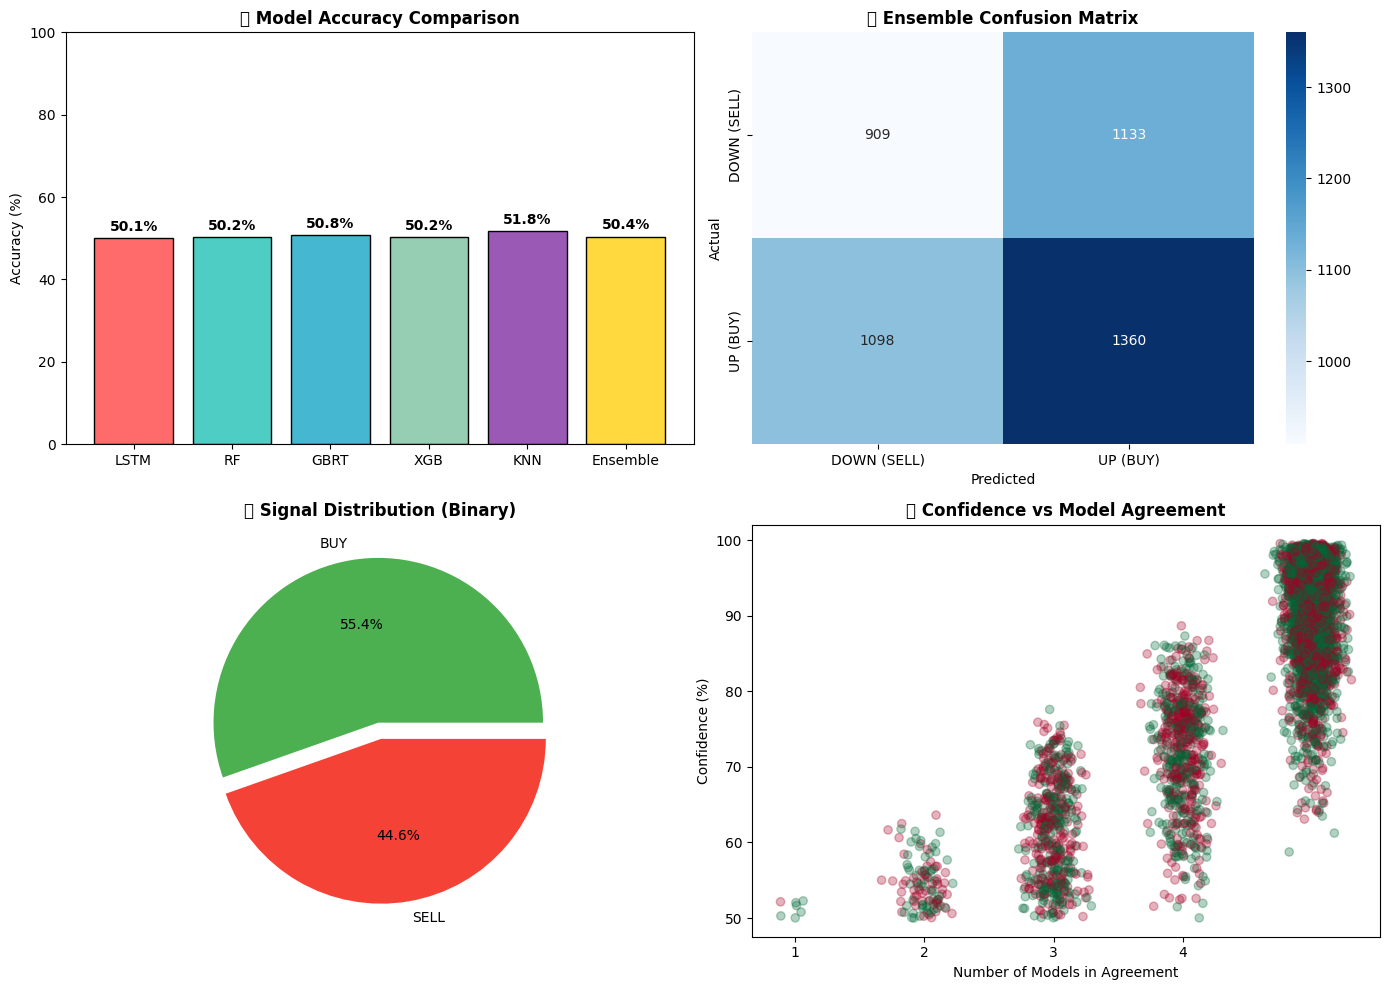


✅ Visualization saved to 'ensemble_results.png'


In [31]:
# Step 15: Visualize Ensemble Results
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("="*70)
print("📊 VISUALIZATION: ENSEMBLE MODEL RESULTS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Model Accuracy Comparison (5 models + ensemble)
ax1 = axes[0, 0]
models = ['LSTM', 'RF', 'GBRT', 'XGB', 'KNN', 'Ensemble']
accuracies = [model_results[m]['accuracy']*100 for m in ['LSTM', 'RandomForest', 'GBRT', 'XGBoost', 'KNN']]
accuracies.append(ensemble_acc * 100)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#9B59B6', '#FFD93D']
bars = ax1.bar(models, accuracies, color=colors, edgecolor='black')
ax1.set_title('🏆 Model Accuracy Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim(0, 100)
for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{acc:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

# Plot 2: Confusion Matrix (Ensemble)
ax2 = axes[0, 1]
cm = confusion_matrix(y_test_class, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['DOWN (SELL)', 'UP (BUY)'],
            yticklabels=['DOWN (SELL)', 'UP (BUY)'])
ax2.set_title('🎯 Ensemble Confusion Matrix', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# Plot 3: Signal Distribution
ax3 = axes[1, 0]
signal_counts = signals_df['signal'].value_counts()
signal_colors = {'BUY': '#4CAF50', 'SELL': '#F44336'}  # Binary: no HOLD
ax3.pie(signal_counts, labels=signal_counts.index, autopct='%1.1f%%',
        colors=[signal_colors.get(s, '#999') for s in signal_counts.index],
        explode=[0.05 for s in signal_counts.index])
ax3.set_title('📈 Signal Distribution (Binary)', fontsize=12, fontweight='bold')

# Plot 4: Confidence by Model Agreement
ax4 = axes[1, 1]
agreement = model_results['Ensemble']['agreement']
confidence = model_results['Ensemble']['confidence']
scatter = ax4.scatter(agreement + np.random.normal(0, 0.1, len(agreement)), 
                     confidence * 100, alpha=0.3, c=ensemble_pred, cmap='RdYlGn')
ax4.set_xlabel('Number of Models in Agreement')
ax4.set_ylabel('Confidence (%)')
ax4.set_title('🤝 Confidence vs Model Agreement', fontsize=12, fontweight='bold')
ax4.set_xticks([1, 2, 3, 4])

plt.tight_layout()
plt.savefig('ensemble_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved to 'ensemble_results.png'")


In [32]:
# Step 16: Generate Live Trading Plan (MID INTRADAY + SCALPING)
print("="*70)
print("💹 LIVE TRADING PLAN - MID INTRADAY TRADER")
print("="*70)

# Get the LATEST data point for live prediction
latest_date = df['Date'].iloc[-1]
latest_price = df['Price'].iloc[-1]

# Get latest prediction from ensemble
latest_signal_idx = len(ensemble_pred) - 1
latest_prediction = ensemble_pred[latest_signal_idx]
latest_proba = ensemble_proba[latest_signal_idx]
latest_confidence = np.max(latest_proba)
latest_agreement = model_results['Ensemble']['agreement'][latest_signal_idx]

# Get volatility to determine trade type
latest_vol_ratio = df['Volatility_Ratio'].iloc[-1] if 'Volatility_Ratio' in df.columns else 1.0

# Determine trade type based on volatility (PURE SCALPING mode)
if latest_vol_ratio > 1.2:
    trade_type = "⚡ SCALP (High Vol)"
    hold_time = f"{PREDICTION_HORIZON}H"
    trade_style = "Quick in/out, tight stops"
elif latest_vol_ratio < 0.8:
    trade_type = "⚡ SCALP (Low Vol)"
    hold_time = f"{PREDICTION_HORIZON}H"
    trade_style = "Quick moves, patient entry"
else:
    trade_type = "⚡ SCALP"
    hold_time = f"{PREDICTION_HORIZON}H"
    trade_style = "Standard scalping approach"

# Get individual model predictions
print("\n🔮 MODEL PREDICTIONS (5 models):")
print("-"*50)
signal_names = ['DOWN (SELL)', 'UP (BUY)']
for model_name in ['LSTM', 'RandomForest', 'GBRT', 'XGBoost', 'KNN']:
    pred = model_results[model_name]['predictions'][latest_signal_idx]
    proba = model_results[model_name]['probabilities'][latest_signal_idx]
    conf = np.max(proba)
    print(f"   {model_name:<15}: {signal_names[pred]:<12} ({conf*100:.1f}%)")

print(f"\n   {'ENSEMBLE':<15}: {signal_names[latest_prediction]:<12} ({latest_confidence*100:.1f}%)")
print(f"   Agreement: {latest_agreement}/5 models")

# Calculate trading levels
current_atr = df['ATR'].iloc[-1] if 'ATR' in df.columns else (df['High'].iloc[-1] - df['Low'].iloc[-1])

print("\n" + "="*70)
print("📋 CURRENT TRADING RECOMMENDATION")
print("="*70)
print(f"\n📅 Date: {latest_date}")
print(f"💰 Current Price: ${latest_price:.2f}")
print(f"📊 Volatility: {latest_vol_ratio:.2f}x average")
print(f"\n🎯 TRADE TYPE: {trade_type}")
print(f"   Hold Time: ~{hold_time}")
print(f"   Style: {trade_style}")

# Adjust stops based on volatility (PURE SCALPING mode)
if "High Vol" in trade_type:
    atr_mult_sl = 1.0   # Tighter stop for high volatility
    atr_mult_tp = 1.5   # Quick profit
elif "Low Vol" in trade_type:
    atr_mult_sl = 1.5   # Slightly wider stop for low vol
    atr_mult_tp = 2.0   # Let it develop
else:
    atr_mult_sl = 1.2   # Standard scalp stops
    atr_mult_tp = 1.8

if latest_prediction == 1:  # UP (BUY)
    entry = latest_price
    stop_loss = entry - (current_atr * atr_mult_sl)
    take_profit_1 = entry + (current_atr * atr_mult_tp)
    take_profit_2 = entry + (current_atr * atr_mult_tp * 1.5)
    take_profit_3 = entry + (current_atr * atr_mult_tp * 2.0)
    
    print(f"\n🟢 SIGNAL: BUY (Long Position)")
    print(f"   Confidence: {latest_confidence*100:.1f}%")
    print(f"   Model Agreement: {latest_agreement}/5")
    print(f"\n📊 BUY PLAN ({trade_type}):")
    print(f"   ├── Entry Price:      ${entry:.2f}")
    print(f"   ├── Stop Loss:        ${stop_loss:.2f} (-${entry-stop_loss:.2f})")
    print(f"   ├── Take Profit 1:    ${take_profit_1:.2f} (+${take_profit_1-entry:.2f})")
    print(f"   ├── Take Profit 2:    ${take_profit_2:.2f} (+${take_profit_2-entry:.2f})")
    print(f"   └── Take Profit 3:    ${take_profit_3:.2f} (+${take_profit_3-entry:.2f})")
    
else:  # DOWN (SELL)
    entry = latest_price
    stop_loss = entry + (current_atr * atr_mult_sl)
    take_profit_1 = entry - (current_atr * atr_mult_tp)
    take_profit_2 = entry - (current_atr * atr_mult_tp * 1.5)
    take_profit_3 = entry - (current_atr * atr_mult_tp * 2.0)
    
    print(f"\n🔴 SIGNAL: SELL (Short Position)")
    print(f"   Confidence: {latest_confidence*100:.1f}%")
    print(f"   Model Agreement: {latest_agreement}/5")
    print(f"\n📊 SELL PLAN ({trade_type}):")
    print(f"   ├── Entry Price:      ${entry:.2f}")
    print(f"   ├── Stop Loss:        ${stop_loss:.2f} (+${stop_loss-entry:.2f})")
    print(f"   ├── Take Profit 1:    ${take_profit_1:.2f} (-${entry-take_profit_1:.2f})")
    print(f"   ├── Take Profit 2:    ${take_profit_2:.2f} (-${entry-take_profit_2:.2f})")
    print(f"   └── Take Profit 3:    ${take_profit_3:.2f} (-${entry-take_profit_3:.2f})")

# Signal strength assessment (5 models now)
if latest_confidence >= 0.7 and latest_agreement >= 5:
    strength = "🔥 VERY STRONG (5/5)"
elif latest_confidence >= 0.65 and latest_agreement >= 4:
    strength = "💪 STRONG (4+/5)"
elif latest_confidence >= 0.6 and latest_agreement >= 3:
    strength = "📊 GOOD (3+/5)"
elif latest_confidence >= 0.55:
    strength = "⚡ MODERATE"
else:
    strength = "⚠️ WEAK - Consider waiting"

print(f"\n📈 Signal Strength: {strength}")

# =============================================================================
# KNN PATTERN ANALYSIS - Similar Historical Setups
# =============================================================================
print("\n" + "="*70)
print("🔍 KNN PATTERN ANALYSIS - Similar Historical Setups")
print("="*70)

# Find similar patterns to current situation
latest_features = X_test_flat[-1].reshape(1, -1)
distances, indices = knn_pattern_finder.kneighbors(latest_features, n_neighbors=10)

# Analyze what happened after similar patterns
similar_outcomes = y_train_class[indices[0]]
up_count = np.sum(similar_outcomes == 1)
down_count = np.sum(similar_outcomes == 0)
total = len(similar_outcomes)

print(f"\n📊 10 Most Similar Historical Patterns:")
print(f"   Went UP:   {up_count}/{total} ({up_count/total*100:.0f}%)")
print(f"   Went DOWN: {down_count}/{total} ({down_count/total*100:.0f}%)")

# Pattern confidence
pattern_confidence = max(up_count, down_count) / total
pattern_direction = "UP (BUY)" if up_count > down_count else "DOWN (SELL)"
print(f"\n   🎯 Pattern Suggestion: {pattern_direction}")
print(f"   📈 Historical Win Rate: {pattern_confidence*100:.0f}%")

# Market regime from KNN
print(f"\n📈 Market Regime Analysis:")
print(f"   Best K for current market: K={model_results['KNN']['best_k']}")
if model_results['KNN']['best_k'] <= 10:
    print(f"   → Market is CHOPPY/REACTIVE - tight stops, quick exits")
else:
    print(f"   → Market is STABLE/TRENDING - can hold positions longer")

# Multi-K consensus
multi_k_preds = []
for k, model in knn_models_multi_k.items():
    pred = model.predict(latest_features)[0]
    multi_k_preds.append(pred)
    
multi_k_consensus = np.mean(multi_k_preds)
print(f"\n🔄 Multi-K Consensus:")
print(f"   K=5,10,20,50 vote: {multi_k_consensus*100:.0f}% bullish")
if multi_k_consensus > 0.6:
    print(f"   → Strong agreement: GO LONG")
elif multi_k_consensus < 0.4:
    print(f"   → Strong agreement: GO SHORT")
else:
    print(f"   → Mixed signals: BE CAUTIOUS")

# Trading tips based on volatility (PURE SCALPING mode)
print("\n" + "="*70)
print("💡 SCALPING TIPS:")
print("="*70)
if "High Vol" in trade_type:
    print("   • High volatility - be quick and decisive")
    print("   • Use tight stops (1x ATR)")
    print("   • Take profit at TP1 quickly")
    print("   • Best during London/NY session overlap")
    print(f"   • KNN suggests: Use K={min(model_results['KNN']['multi_k_results'], key=model_results['KNN']['multi_k_results'].get)} for reactive scalping")
elif "Low Vol" in trade_type:
    print("   • Low volatility - be patient on entries")
    print("   • Use slightly wider stops (1.5x ATR)")
    print("   • Wait for clearer breakouts")
    print("   • Consider scaling in on confirmation")
    print(f"   • KNN suggests: Use K={max(model_results['KNN']['multi_k_results'], key=model_results['KNN']['multi_k_results'].get)} for stable conditions")
else:
    print("   • Standard volatility - balanced approach")
    print("   • Watch price action for confirmation")
    print("   • Adjust SL/TP based on market reaction")
    print(f"   • KNN suggests: Use moderate K values")

print("\n" + "="*70)
print("📝 TRADING RECOMMENDATIONS:")
print("="*70)
print(f"   • Current Confidence: {latest_confidence*100:.1f}%")
print(f"   • Model Agreement: {latest_agreement}/5")
print(f"   • Recommended: Only trade when confidence >= 60%")
print(f"   • Best signals: When 4+ models agree")
print("="*70)


💹 LIVE TRADING PLAN - MID INTRADAY TRADER

🔮 MODEL PREDICTIONS (5 models):
--------------------------------------------------
   LSTM           : DOWN (SELL)  (87.1%)
   RandomForest   : UP (BUY)     (61.1%)
   GBRT           : UP (BUY)     (76.1%)
   XGBoost        : DOWN (SELL)  (91.8%)
   KNN            : UP (BUY)     (83.5%)

   ENSEMBLE       : DOWN (SELL)  (51.6%)
   Agreement: 2/5 models

📋 CURRENT TRADING RECOMMENDATION

📅 Date: 2025-12-22 09:00:00
💰 Current Price: $4414.47
📊 Volatility: 1.04x average

🎯 TRADE TYPE: ⚡ SCALP
   Hold Time: ~2H
   Style: Standard scalping approach

🔴 SIGNAL: SELL (Short Position)
   Confidence: 51.6%
   Model Agreement: 2/5

📊 SELL PLAN (⚡ SCALP):
   ├── Entry Price:      $4414.47
   ├── Stop Loss:        $4428.02 (+$13.55)
   ├── Take Profit 1:    $4394.15 (-$20.32)
   ├── Take Profit 2:    $4383.99 (-$30.48)
   └── Take Profit 3:    $4373.83 (-$40.64)

📈 Signal Strength: ⚠️ WEAK - Consider waiting

🔍 KNN PATTERN ANALYSIS - Similar Historical Set

In [33]:
# Step 17: Save All 5 Models
print("="*70)
print("💾 SAVING ALL 5 MODELS")
print("="*70)

# Save LSTM model
lstm_model.save('GoldEnsemble_LSTM.keras')
print("✅ LSTM model saved: GoldEnsemble_LSTM.keras")

# Save Random Forest
joblib.dump(rf_model, 'GoldEnsemble_RF.joblib')
print("✅ Random Forest saved: GoldEnsemble_RF.joblib")

# Save GBRT
joblib.dump(gbrt_model, 'GoldEnsemble_GBRT.joblib')
print("✅ GBRT saved: GoldEnsemble_GBRT.joblib")

# Save XGBoost (using joblib for compatibility)
joblib.dump(xgb_model, 'GoldEnsemble_XGB.joblib')
print("✅ XGBoost saved: GoldEnsemble_XGB.joblib")

# Save KNN
joblib.dump(knn_model, 'GoldEnsemble_KNN.joblib')
print("✅ KNN model saved: GoldEnsemble_KNN.joblib")

# Save scaler
joblib.dump(scaler, 'scaler.joblib')
print("✅ Scaler saved: scaler.joblib")

print("\n" + "="*70)
print("📁 ALL FILES SAVED:")
print("="*70)
print("   Models (5 total):")
print("   ├── GoldEnsemble_LSTM.keras (LSTM neural network)")
print("   ├── GoldEnsemble_RF.joblib (Random Forest)")
print("   ├── GoldEnsemble_GBRT.joblib (Gradient Boosted Trees)")
print("   ├── GoldEnsemble_XGB.joblib (XGBoost)")
print("   └── GoldEnsemble_KNN.joblib (K-Nearest Neighbors)")
print("   Utilities:")
print("   └── scaler.joblib (Feature scaler)")


💾 SAVING ALL 5 MODELS
✅ LSTM model saved: GoldEnsemble_LSTM.keras
✅ Random Forest saved: GoldEnsemble_RF.joblib
✅ GBRT saved: GoldEnsemble_GBRT.joblib
✅ XGBoost saved: GoldEnsemble_XGB.joblib
✅ KNN model saved: GoldEnsemble_KNN.joblib
✅ Scaler saved: scaler.joblib

📁 ALL FILES SAVED:
   Models (5 total):
   ├── GoldEnsemble_LSTM.keras (LSTM neural network)
   ├── GoldEnsemble_RF.joblib (Random Forest)
   ├── GoldEnsemble_GBRT.joblib (Gradient Boosted Trees)
   ├── GoldEnsemble_XGB.joblib (XGBoost)
   └── GoldEnsemble_KNN.joblib (K-Nearest Neighbors)
   Utilities:
   └── scaler.joblib (Feature scaler)


In [34]:
# Step 18: Save Configuration and Summary
print("="*70)
print("📋 SAVING CONFIGURATION")
print("="*70)

# Save complete ensemble configuration
ensemble_config = {
    'models': {
        'lstm': 'GoldEnsemble_LSTM.keras',
        'random_forest': 'GoldEnsemble_RF.joblib',
        'gbrt': 'GoldEnsemble_GBRT.joblib',
        'xgboost': 'GoldEnsemble_XGB.joblib'
    },
    'scaler': 'scaler.joblib',
    'model_type': 'ensemble_classification',
    'classes': ['DOWN (SELL)', 'UP (BUY)'],
    'window_size': WINDOW_SIZE,
    'timeframe': TIMEFRAME,
    'feature_columns': feature_columns,
    'num_features': len(feature_columns),
    'accuracy': {
        'lstm': float(model_results['LSTM']['accuracy'] * 100),
        'random_forest': float(model_results['RandomForest']['accuracy'] * 100),
        'gbrt': float(model_results['GBRT']['accuracy'] * 100),
        'xgboost': float(model_results['XGBoost']['accuracy'] * 100),
        'ensemble': float(ensemble_acc * 100)
    },
    'training_info': {
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'training_date': datetime.now().isoformat()
    }
}

with open('ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f, indent=2)

print("✅ Configuration saved: ensemble_config.json")

# Print final summary
print("\n" + "="*70)
print("🎉 ENSEMBLE TRADING SYSTEM COMPLETE!")
print("="*70)

print("\n📊 MODEL ACCURACY SUMMARY:")
print("-"*50)
for model_name in ['LSTM', 'RandomForest', 'GBRT', 'XGBoost']:
    acc = model_results[model_name]['accuracy'] * 100
    print(f"   {model_name:<15}: {acc:.2f}%")
print(f"   {'ENSEMBLE':<15}: {ensemble_acc*100:.2f}%")

print("\n🎯 USAGE:")
print("   1. Run all cells to train the models")
print("   2. Check 'Step 16' for live trading signals")
print("   3. Use confidence and agreement to filter signals")
print("   4. Strong signals: ≥60% confidence + 3/4 model agreement")

print("\n" + "="*70)


📋 SAVING CONFIGURATION
✅ Configuration saved: ensemble_config.json

🎉 ENSEMBLE TRADING SYSTEM COMPLETE!

📊 MODEL ACCURACY SUMMARY:
--------------------------------------------------
   LSTM           : 50.09%
   RandomForest   : 50.20%
   GBRT           : 50.84%
   XGBoost        : 50.22%
   ENSEMBLE       : 50.42%

🎯 USAGE:
   1. Run all cells to train the models
   2. Check 'Step 16' for live trading signals
   3. Use confidence and agreement to filter signals
   4. Strong signals: ≥60% confidence + 3/4 model agreement



# ✅ Training Complete!

## Next Steps:
1. Copy `GoldPriceLSTM.onnx` to your MT5 `MQL5\Files\` folder
2. Copy `mt5_model_config.json` to `MQL5\Files\` folder  
3. Use the `GoldMLSignalEA.mq5` Expert Advisor to trade with the model

## Model Performance:
- The LSTM model predicts next-day gold prices
- Generates BUY/SELL/HOLD signals based on predicted price movement
- Uses 60-day sliding window of historical data
